In [17]:
import numpy as np
 
def pack(W_list):
    w = np.array([])
    for W in W_list:
        w = np.append(w, W)
    return w

def unpack(w, arch):
    n_layers = arch['n_layers']
    sizes = arch['sizes']
 
    W_list = [None] * (n_layers-1)
 
    i_from = 0
    for k in range(n_layers-1):
        size_cur = sizes[k]
        size_next = sizes[k+1]
        W_list[k] = w[i_from : i_from + size_cur * size_next].reshape((size_next, size_cur))
        i_from += size_cur * size_next

    return W_list


def compute_vals(X, W_list, arch):
    z_list = []
    u_list = []
    z_list.append(X.T)
    for i in range(arch['n_layers'] - 1):
        u_list.append(np.dot(W_list[i], z_list[-1]))
        z_list.append(arch['afuns'][i](u_list[-1]))
    return z_list, u_list


def compute_grad(W_list, Z_list, U_list, Gz, arch):
    G_list = []
    gz = Gz
    for k in range(arch['n_layers'] - 1)[::-1]:
        gu = arch['dafuns'][k](U_list[k]) * gz
        gz = np.dot(W_list[k].T, gu)
        G_list.insert(0, np.dot(gu, Z_list[k].T))
    return G_list




def loss_func(w, X, reg_coef, arch, prep_hess_vec=False):
    n = X.shape[0]
    W_list = unpack(w, arch)
    Z_list, U_list = compute_vals(X, W_list, arch)
    
    f = 1. / (2*n) * np.sum((Z_list[-1] - X.T)**2) + reg_coef/2. * np.sum(w**2)

    Gz = 1. / n * (Z_list[-1] - X.T)
    G_list = compute_grad(W_list, Z_list, U_list, Gz, arch)
    g = pack(G_list) + reg_coef * w

    if prep_hess_vec:
        return f, g, (Z_list, U_list)
    return f, g


def gn_hess_vec(w, v, extra, reg_coef, arch):
    V_list = unpack(v, arch)
    W_list = unpack(w, arch)
    Z_list, U_list = extra
    gz_v = compute_dir_derivs(W_list, V_list, Z_list, U_list, arch)

    g_w_list = []
    gg_z = 1. / gz_v.shape[1] * gz_v
    for k in range(arch['n_layers'] - 1)[::-1]:
        gg_u = arch['dafuns'][k](U_list[k]) * gg_z
        gg_z = np.dot(W_list[k].T, gg_u)
        g_w_list.append(np.dot(gg_u, Z_list[k].T))
    return pack(g_w_list[::-1]) + reg_coef * v


def compute_dir_derivs(W_list, V_list, Z_list, U_list, arch):
    gz_v_curr = np.zeros_like(Z_list[-1])
    for k in range(arch['n_layers'] - 1):
        gu_v = np.dot(V_list[k], Z_list[k]) + np.dot(W_list[k], gz_v_curr)
        gz_v_curr = arch['dafuns'][k](U_list[k]) * gu_v
    return gz_v_curr

In [31]:
import numpy as np
import scipy as sp
from scipy import linalg, special,optimize
import copy
import time
from scipy.optimize.linesearch import line_search_wolfe2, line_search_armijo
from scipy.linalg import cho_factor, cho_solve
import math

def lbfgs_compute_dir(sy_hist, g):
    d = -g
    if len(sy_hist) == 0:
        return d
    rho = []
    s_last, y_last = sy_hist[-1]
    multiplier = np.dot(s_last, y_last) / np.dot(y_last, y_last)
    alphas = []
    for s, y in reversed(sy_hist):
        rho.insert(0, 1. / np.dot(s, y))
        alphas.insert(0, rho[0] * np.dot(s,d))
        d = d - alphas[0] * y
    d = multiplier * d
    for i, (s, y) in enumerate(sy_hist):
        beta = rho[i] * np.dot(y, d)
        d = d + s*(alphas[i] - beta)
    return d


def lbfgs(func, x0, tol=1e-5, max_iter=500, max_n_evals=1000, m=10,
c1=1e-4, c2=0.9, disp=False, trace=False):
    start_time = time.time()
    iteration = 0
    status = 1
    x = copy.copy(x0)
    tol_hist = []
    n_eval_hist = []
    eval_t_hist = []
    f_hist = []
    sy_hist = []
    n_evals = 0
    
    if disp:
        print '%-12s%-12s%-12s%-12s%-12s' % ('iteration', 'func', 'cur_tol', 'n_evals', 'time') 

    f, g = func(x)
    n_evals += 1
    while iteration < max_iter and n_evals < max_n_evals:
        iteration += 1
        g_prev = g
        x_prev = x
        d = lbfgs_compute_dir(sy_hist, g)
        alpha, fc, gc, new_fval, old_fval, new_slope = line_search_wolfe2(lambda x: func(x)[0], 
                                 lambda x: func(x)[1], 
                                 x, 
                                 d, 
                                 c1=c1, 
                                 c2=c2)
        n_evals += gc + fc
        if alpha is None:
            alpha, f_count, f_val_at_alpha = line_search_armijo(lambda x: func(x)[0],
                                     x, 
                                     d, 
                                     g, 
                                     f, 
                                     c1=c1)
            n_evals += f_count
        x = x + alpha * d
        f, g = func(x)
        n_evals += 1
        if len(sy_hist) == m:
            sy_hist.pop(0)
        sy_hist.append((x - x_prev, g - g_prev))
        cur_tol = np.linalg.norm(g, ord=np.inf)
        eval_t = time.time()-start_time
        if disp:
            print '%-12i%-12f%-12f%-12i%-12f' % (iteration, f, cur_tol, n_evals, eval_t) 
            
        if trace:
            f_hist.append(f)
            tol_hist.append(cur_tol)
            n_eval_hist.append(n_evals)
            eval_t_hist.append(eval_t)
        
        if cur_tol < tol:
            status = 0
            break
            
    if trace:
        return (x, f, status, {'f':np.array(f_hist),
                            'norm_g':np.array(tol_hist),
                            'n_evals':np.array(n_eval_hist),
                            'elaps_t':np.array(eval_t_hist),
                           })
    
    return (x, f, status)


def hfn(func, x0, hess_vec, tol=1e-5, max_iter=500, c1=1e-4, c2=0.9,
disp=False, trace=False):
    start_time = time.time()
    iteration = 0
    status = 1
    x = copy.copy(x0)
    tol_hist = []
    eval_t_hist = []
    f_hist = []
    sy_hist = []
    
    if disp:
        print '%-12s%-12s%-12s%-12s' % ('iteration', 'func', 'cur_tol', 'time') 

    f, g, extra = func(x)
    while iteration < max_iter:
        iteration += 1

        matvec = lambda dd: hess_vec(x, dd, extra)
        d, cg_status = cg(matvec, -g, np.random.normal(0,1,g.shape), disp=False)
        #assert cg_status == 0

        alpha, fc, gc, new_fval, old_fval, new_slope = line_search_wolfe2(lambda x: func(x)[0], 
                                 lambda x: func(x)[1], 
                                 x, 
                                 d, 
                                 c1=c1, 
                                 c2=c2)
        if alpha is None:
            alpha, f_count, f_val_at_alpha = line_search_armijo(lambda x: func(x)[0],
                                     x, 
                                     d, 
                                     g, 
                                     f, 
                                     c1=c1)
        x_prev = x
        x = x + alpha * d
        f, g, extra = func(x)

        cur_tol = np.linalg.norm(g)
        eval_t = time.time()-start_time
        
        if disp:
            print '%-12i%-12f%-12f%-12f' % (iteration, f, cur_tol, eval_t) 
            
        if trace:
            f_hist.append(f)
            tol_hist.append(cur_tol)
            eval_t_hist.append(eval_t)
        
        if cur_tol < tol:
            status = 0
            break
            
    if trace:
        return (x, f, status, {'f':np.array(f_hist),
                            'norm_g':np.array(tol_hist),
                            'elaps_t':np.array(eval_t_hist),
                           })
    
    return (x, f, status)

def cg(matvec, b, x0, tol=1e-5, max_iter=None, disp=False, trace=False):
    iteration = 0
    
    if max_iter is None:
        max_iter = len(x0)
    
    status = 1
    g = matvec(x0) - b
    d = -g
    u = matvec(d)
    x = copy.copy(x0)
    tol_hist = []
    while iteration < max_iter:
        iteration += 1
        
        gg_prev = np.dot(g, g)
        
        alpha = gg_prev / np.dot(d, u)
        x = x + alpha * d
        g = g + alpha * u

        curr_tol = np.max(np.abs(matvec(x) - b))
        
        if disp:
            print '%-12s%-12s' % (iteration, curr_tol)
            
        if trace:
            tol_hist.append(curr_tol)
        
        b_norm = np.max(np.abs(b))
        eta = min(0.5, math.sqrt(b_norm))
        if curr_tol < eta * b_norm:
            status = 0
            break
            
        beta = np.dot(g, g) / gg_prev
        d = -g + beta * d
        u = matvec(d)
        
    if trace:
        return (x, status, {'norm_r':np.array(tol_hist)})
    
    return (x, status)

def ncg(func, x0, tol=1e-4, max_iter=500, max_n_evals=1000, c1=1e-4, c2=0.1, disp=False, trace=False):
    
    start_time = time.time()
    iteration = 0
    status = 1
    x = copy.copy(x0)
    f, g = func(x)
    n_evals = 1
    tol_hist = []
    n_eval_hist = []
    eval_t_hist = []
    f_hist = []
    d = - g
    
    if disp:
        print '%-12s%-12s%-12s%-12s%-12s' % ('iteration', 'func', 'cur_tol', 'n_evals', 'time') 

    
    while iteration < max_iter and n_evals < max_n_evals:
        iteration += 1
        
        lam, fc, gc, new_fval, old_fval,  new_slope = line_search_wolfe2(lambda x: func(x)[0], 
                                 lambda x: func(x)[1], 
                                 x, 
                                 d, 
                                 c1=c1, 
                                 c2=c2)
        n_evals += gc + fc
        if lam is None:
            lam, f_count, f_val_at_alpha = line_search_armijo(lambda x: func(x)[0],
                                     x, 
                                     d, 
                                     g, 
                                     f, 
                                     c1=c1)
            n_evals += f_count

        x = x + lam * d
        
        g_prev = g
        f, g = func(x)
        n_evals += 1
        
        beta = (np.dot(g, g) - np.dot(g, g_prev)) / np.dot(g_prev, g_prev)
        d = -g + beta * d
        
        cur_tol = np.linalg.norm(g, ord=np.inf)
        eval_t = time.time()-start_time
        
        if disp:
            print '%-12i%-12f%-12f%-12i%-12f' % (iteration, f, cur_tol, n_evals, eval_t) 
            
        if trace:
            f_hist.append(f)
            tol_hist.append(cur_tol)
            n_eval_hist.append(n_evals)
            eval_t_hist.append(eval_t)
        
        if cur_tol < tol:
            status = 0
            break
            
    if trace:
        return (x, f, status, {'f':np.array(f_hist),
                            'norm_g':np.array(tol_hist),
                            'n_evals':np.array(n_eval_hist),
                            'elaps_t':np.array(eval_t_hist),
                           })
    
    return (x, f, status)

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
from sklearn.cross_validation import train_test_split

In [4]:
X, y = digits.data, digits.target
X = X / X.max()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print X_train.shape, X_test.shape

(1437, 64) (360, 64)


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def identity(x):
    return x

def d_identity(x):
    return np.ones_like(x)

In [6]:
arch1 = {
    'n_layers': 3,
    'sizes': [64, 2, 64],
    'afuns': [sigmoid, sigmoid],
    'dafuns': [d_sigmoid, d_sigmoid]
}

arch2 = {
    'n_layers': 5,
    'sizes': [64, 30, 2, 30, 64],
    'afuns': [sigmoid, identity, sigmoid, sigmoid],
    'dafuns': [d_sigmoid, d_identity, d_sigmoid, d_sigmoid],
}

def GetWeights(arch):
    W_list = []
    for i in range(arch['n_layers']-1):
        W_list.append(np.random.normal(loc=0.0, scale=1.0, size=(arch['sizes'][i], arch['sizes'][i + 1])))
    return W_list

W1_list = GetWeights(arch1)
W2_list = GetWeights(arch2)

reg_coef = 1. / len(X)

In [36]:
func1 = lambda w: loss_func(w, X, reg_coef, arch1)
func1_extra = lambda w: loss_func(w, X, reg_coef, arch1, prep_hess_vec=True)
hess_vec1 = lambda ww, vv, eextra: gn_hess_vec(ww, vv, eextra, reg_coef, arch1)

func2 = lambda w: loss_func(w, X, reg_coef, arch2)
func2_extra = lambda w: loss_func(w, X, reg_coef, arch2, prep_hess_vec=True)
hess_vec2 = lambda ww, vv, eextra: gn_hess_vec(ww, vv, eextra, reg_coef, arch2)
w01 = pack(W1_list)
w02 = pack(W2_list)

In [38]:
from collections import defaultdict

In [47]:
w0 = [w01, w02]
func = [func1, func2]
func_extra = [func1_extra, func2_extra]
hess_vec = [hess_vec1, hess_vec2]
w = defaultdict(dict)
f = defaultdict(dict)
hist = defaultdict(dict)
for i in range(2):
    w[i]['lbfgs'], f[i]['lbfgs'], status, hist[i]['lbfgs'] = lbfgs(func[i], w0[i], tol=1e-5, max_iter=500, max_n_evals=3000, m=10,
    c1=1e-4, c2=0.9, disp=False, trace=True)
    print 'lbfgs complete'
    w[i]['hfn'], f[i]['hfn'], status, hist[i]['hfn'] = hfn(func_extra[i], w0[i], 
                                                          hess_vec[i], tol=1e-5, max_iter=500, c1=1e-4, c2=0.9,
                                                            disp=False, trace=True)
    print 'hfn complete'
    w[i]['ncg'], f[i]['ncg'], status, hist[i]['ncg'] = ncg(func[i], w0[i], tol=1e-4, max_iter=500, max_n_evals=1000, c1=1e-4, c2=0.9, disp=False, trace=True)  
    print 'ncg complete'  

lbfgs complete
hfn complete


/home/necnec/progs/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


ncg complete


/home/necnec/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in square


lbfgs complete
hfn complete
ncg complete


In [40]:

%matplotlib inline
import matplotlib.pyplot as plt

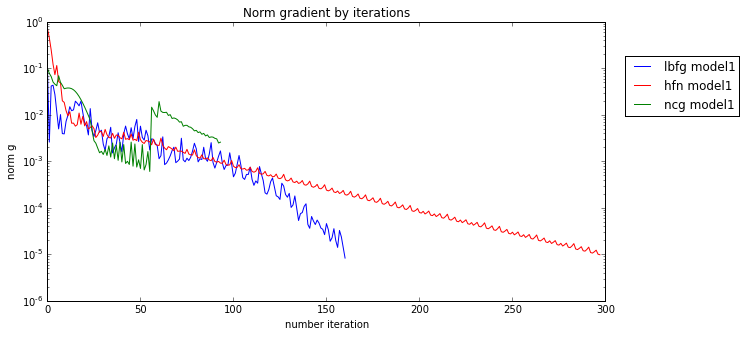

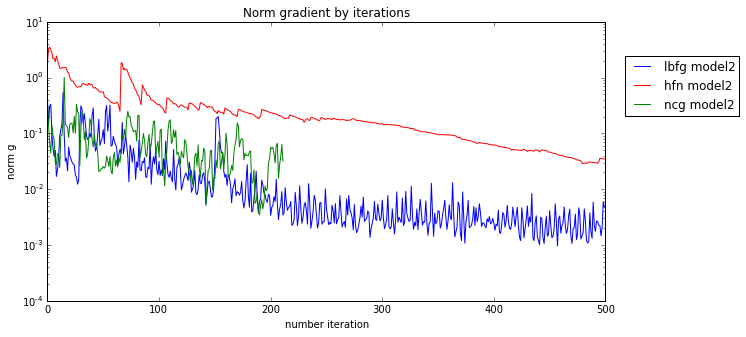

In [49]:
for i, model_name in enumerate(['model1', 'model2']):
    plt.figure(figsize=(10,5))
    arr = hist[i]['lbfgs']['norm_g']
    plt.plot(range(len(arr)), arr, label='lbfg '+ model_name, color = 'blue')
    arr = hist[i]['hfn']['norm_g']
    plt.plot(range(len(arr)), arr, label='hfn '+ model_name, color = 'red')
    arr = hist[i]['ncg']['norm_g']
    plt.plot(range(len(arr)), arr, label='ncg '+ model_name, color = 'green')
    plt.xlabel('number iteration')
    plt.ylabel('norm g')
    plt.yscale('log')
    plt.title('Norm gradient by iterations')
    plt.legend(bbox_to_anchor=(1.25, 0.9))
    plt.show()


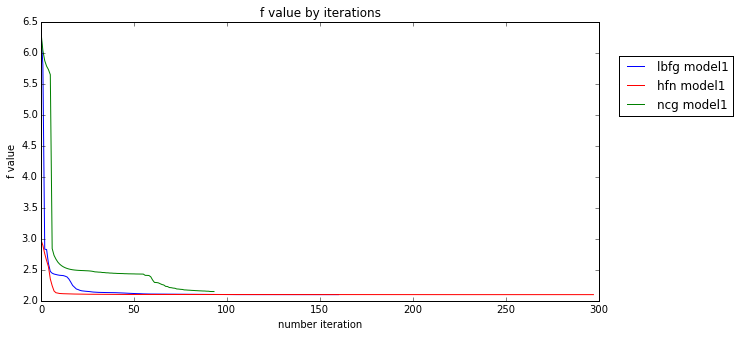

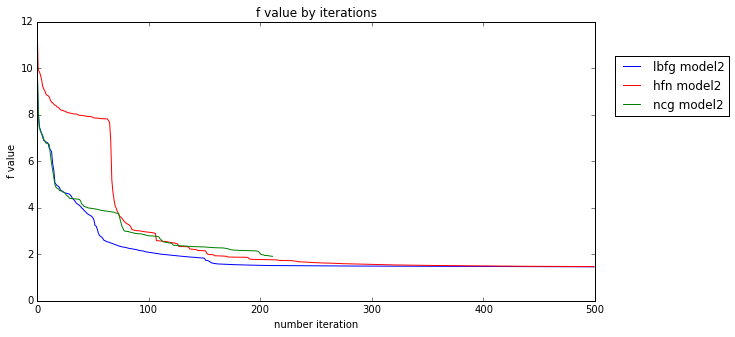

In [51]:
for i, model_name in enumerate(['model1', 'model2']):
    plt.figure(figsize=(10,5))
    arr = hist[i]['lbfgs']['f']
    plt.plot(range(len(arr)), arr, label='lbfg '+ model_name, color = 'blue')
    arr = hist[i]['hfn']['f']
    plt.plot(range(len(arr)), arr, label='hfn '+ model_name, color = 'red')
    arr = hist[i]['ncg']['f']
    plt.plot(range(len(arr)), arr, label='ncg '+ model_name, color = 'green')
    plt.xlabel('number iteration')
    plt.ylabel('f value')
    plt.title('f value by iterations')
    plt.legend(bbox_to_anchor=(1.25, 0.9))
    plt.show()


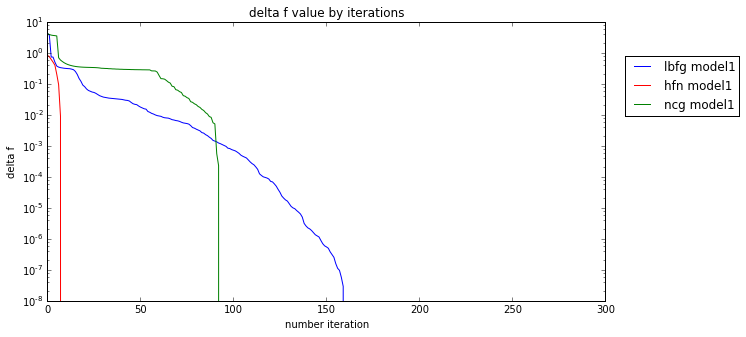

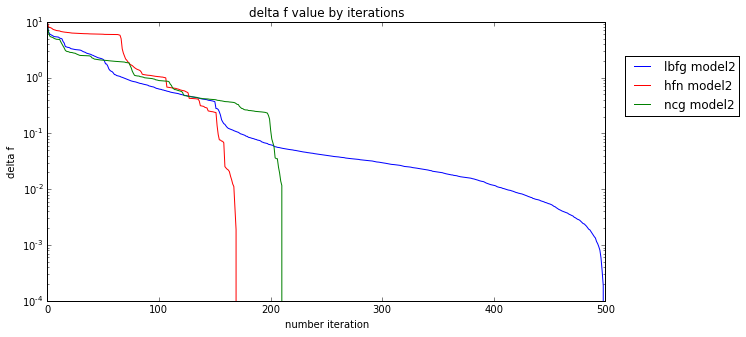

In [53]:
for i, model_name in enumerate(['model1', 'model2']):
    plt.figure(figsize=(10,5))
    arr = hist[i]['lbfgs']['f']
    plt.plot(range(len(arr)), arr - f[i]['lbfgs'], label='lbfg '+ model_name, color = 'blue')
    arr = hist[i]['hfn']['f']
    plt.plot(range(len(arr)), arr - f[i]['ncg'], label='hfn '+ model_name, color = 'red')
    arr = hist[i]['ncg']['f']
    plt.plot(range(len(arr)), arr - f[i]['ncg'], label='ncg '+ model_name, color = 'green')
    plt.xlabel('number iteration')
    plt.ylabel('delta f')
    plt.yscale('log')
    plt.title('delta f value by iterations')
    plt.legend(bbox_to_anchor=(1.25, 0.9))
    plt.show()

In [60]:
i = 0
def visualize(w,i):
    f,g, (Z_list, U_list) = func_extra[i](w)
    w_central = Z_list[len(Z_list)/2]
    plt.scatter(w_central[0,:], w_central[1,:], c=list(1. * y/len(y)))
    plt.show()

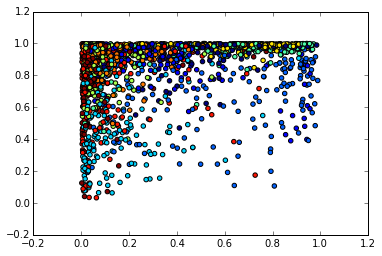

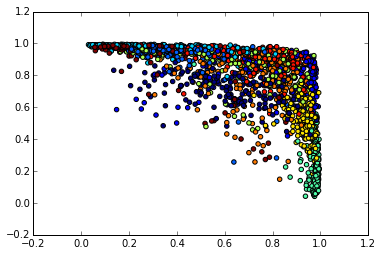

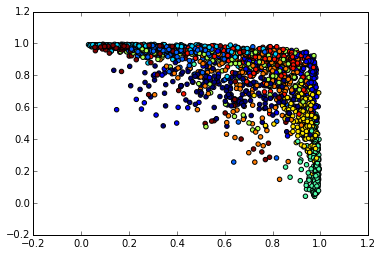

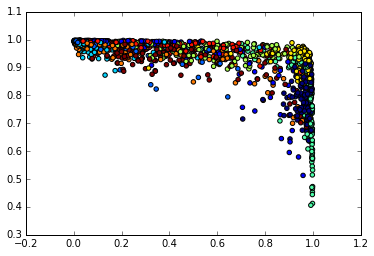

In [58]:
visualize(w01)
visualize(w[0]['lbfgs'])
visualize(w[0]['hfn'])
visualize(w[0]['ncg'])

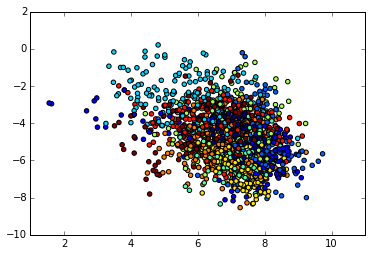

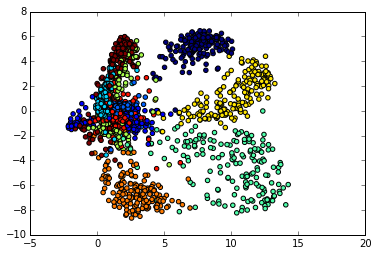

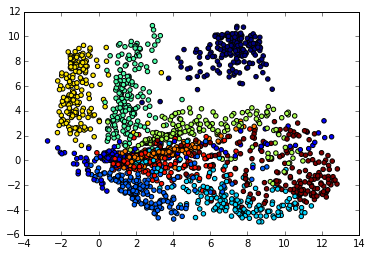

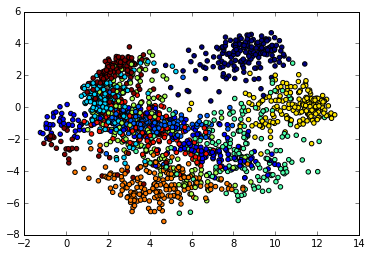

In [62]:
visualize(w02, 1)
visualize(w[1]['lbfgs'], 1)
visualize(w[1]['hfn'], 1)
visualize(w[1]['ncg'], 1)